# LSTM Model for Vessel Trajectory Prediction

## Introduction: Deep Learning Time Series Approach

This notebook implements **Long Short-Term Memory (LSTM)** neural networks for vessel trajectory prediction. Unlike tree-based models (LightGBM) that use engineered lag features, LSTM models directly process raw time sequences, automatically learning temporal dependencies and patterns.

### Why LSTM for Trajectory Prediction?

**Advantages:**
- **Temporal modeling**: LSTM cells maintain memory of past states, capturing long-term dependencies in vessel movement
- **Sequence learning**: Processes entire sequences rather than individual feature vectors, learning patterns like acceleration, deceleration, and course changes
- **Automatic feature extraction**: No need for manual lag feature engineering; the model learns relevant temporal patterns from raw data

**Architecture:**
- **Stacked LSTM layers**: Two-layer architecture (128 → 64 units) to capture hierarchical temporal patterns
- **Bidirectional processing**: Sequential processing of lookback windows to predict future positions
- **Multi-output regression**: Simultaneous prediction of LAT and LON coordinates

### Model Architecture Details

The model uses a **stacked LSTM** architecture:
1. **Input layer**: Sequences of shape `(lookback_steps, n_features)` where features are LAT, LON, SOG, COG
3. **First LSTM layer** (128 units, return_sequences=True): Processes full sequence, outputs hidden states at each timestep
4. **Dropout** (0.0): Currently disabled, can be tuned for regularization
5. **Second LSTM layer** (64 units, return_sequences=False): Aggregates temporal information into final hidden state
6. **Dense layers** (32 → 2): Maps LSTM output to LAT/LON predictions

**Training strategy:**
- **Huber loss** (delta=0.3): Robust to outliers in trajectory data
- **Adam optimizer** (lr=0.0005, clipnorm=1.0): Gradient clipping prevents exploding gradients
- **Early stopping**: Monitors validation loss with patience=8 to prevent overfitting
- **Learning rate reduction**: Reduces LR by 50% when validation loss plateaus (patience=6)


## 1. Imports and Setup


In [1]:
# ====== SYSTEM IMPORTS ======
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# ====== STANDARD LIBRARIES ======
import pandas as pd
import numpy as np

# ====== TENSORFLOW/KERAS (MODULAR APPROACH) ======
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import callbacks, optimizers, losses

# ====== LOCAL MODULES ======
from ml_logic.data_preprocessing import clean_data, resample_pings, create_LSTM_sets, scale_LSTM_data
from ml_logic.model_evaluation import plot_training_history
from ml_logic.metric import HaversineMAE

# ====== JUPYTER MAGIC ======
%load_ext autoreload
%autoreload 2

## 2. Data Loading and Preprocessing

Load raw AIS data and apply cleaning/resampling to prepare sequences for LSTM training.

**Preprocessing steps:**
- **Cleaning**: Remove duplicates, handle missing values, filter invalid records
- **Resampling**: Uniformize to 10-minute intervals (balance between granularity and sequence length)
- **Sequence creation**: Sliding windows of lookback periods to predict horizon periods


In [2]:
# get initial data frame
df = pd.read_parquet("../data/raw/AIS_merged_lon-95.0to-77.2_lat22.5to29.5_20241101to20241130.parquet")

In [3]:
#clean data
df = clean_data(df)
#resample data
df_resampled = resample_pings(df, interval="10min")

/Users/pablorougerie/code/Projets/shanty_project/ml_logic/data_preprocessing.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dimension_cols] = df[dimension_cols].replace(0, np.nan)


## 3. Configuration Setup

Define prediction horizons and training parameters. Lookback periods are set proportionally to horizons to ensure fair comparison with ML models (which use lag features proportional to horizon).


In [4]:
configurations = [
    (12, 6, "1h"),   # lookback 2h, horizon 1h
    (18, 18, "3h"),  # lookback 2h, horizon 3h
    (36, 36, "6h"),  # lookback 2h, horizon 6h
    (72, 72, "12h"), # lookback 2h, horizon 12h
    (96, 144, "24h"), # lookback 2h, horizon 24h
]

# Training parameters
n_train = 200000
n_val = 60000
batch_size = 256
epochs = 30
random_state = 273

## 4. Model Architecture and Training Function

Define the LSTM architecture and training pipeline. The model is designed to process sequences of vessel states (LAT, LON, SOG, COG) and predict future positions.


In [ ]:
# ====== INITIALIZE RESULTS STORAGE ======
# Global DataFrame to store all results across configurations
import gc

if 'lstm_results_df' not in globals():
    lstm_results_df = pd.DataFrame()
    print("Results DataFrame initialized")
else:
    print(f"Results DataFrame already exists with {len(lstm_results_df)} configurations")


✓ Results DataFrame initialized


In [ ]:
# ====== MODEL ARCHITECTURE ======
def create_model(time_sequence_length, n_features, n_targets):
    """
    Create LSTM model architecture for vessel trajectory prediction.

    Architecture choices:
    - Stacked LSTM: Two layers (128→64) to capture hierarchical temporal patterns
    - LSTM units: 128 in first layer (capture complex patterns), 64 in second (aggregate information)
    - return_sequences=True in first layer: Preserve temporal structure for second layer
    - tanh activation: Standard for LSTM, bounded output prevents gradient explosion
    - recurrent_dropout=0: Disabled for now, can be tuned if overfitting occurs
    - Dropout(0.0): Currently disabled, can be increased for regularization
    - Dense(32): Intermediate layer to map LSTM output to prediction space
    - Dense(n_targets): Final layer outputs LAT and LON coordinates
    """
    model = models.Sequential([
        layers.Input(shape=(time_sequence_length, n_features)),
        layers.LSTM(units=128, return_sequences=True, activation="tanh", recurrent_dropout=0),  # First LSTM: process full sequence
        layers.Dropout(0.0),  # Dropout disabled; can be tuned (0.1-0.3) if overfitting
        layers.LSTM(units=64, return_sequences=False, activation="tanh", recurrent_dropout=0),  # Second LSTM: aggregate to single state
        layers.Dropout(0.0),  # Dropout disabled; can be tuned if needed
        layers.Dense(32, activation="relu"),  # Intermediate layer: non-linear mapping
        layers.Dense(n_targets)  # Output layer: LAT and LON predictions
    ])
    return model

# ====== HELPER FUNCTION FOR ONE CONFIGURATION ======
import matplotlib.pyplot as plt

def train_lstm_config(lookback_steps, horizon_steps, horizon_name):
    """
    Train LSTM for one configuration and save results to global DataFrame.

    Returns:
        history: Training history for plotting
    """
    print(f"\n{'='*60}")
    print(f"Configuration: {horizon_name} (lookback={lookback_steps*10}min, horizon={horizon_steps*10}min)")
    print(f"Total sequence length needed: {lookback_steps + horizon_steps} steps ({(lookback_steps + horizon_steps)*10}min)")
    print(f"{'='*60}\n")

    # 1. Create LSTM datasets
    print("1. Creating LSTM datasets...")
    X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq = create_LSTM_sets(
        df=df_resampled,
        lookback=lookback_steps,
        horizon=horizon_steps,
        test_size=0.2,
        val_size=0.2,
        random_state=random_state,
        min_nb_seq=200
    )

    # Extract data statistics
    n_train_sequences = X_train_seq.shape[0]
    n_val_sequences = X_val_seq.shape[0]
    n_test_sequences = X_test_seq.shape[0]

    print(f"\n   Available sequences:")
    print(f"      Train: {n_train_sequences:,} sequences")
    print(f"      Val: {n_val_sequences:,} sequences")
    print(f"      Test: {n_test_sequences:,} sequences")

    if n_train_sequences < 10000:
        print(f"      WARNING: Low train sequences ({n_train_sequences:,})")
    if n_val_sequences < 5000:
        print(f"      WARNING: Low val sequences ({n_val_sequences:,})")

    # 2. Scale datasets
    print("\n2. Scaling datasets...")
    X_train_sc, X_val_sc, X_test_sc = scale_LSTM_data(
        X_train=X_train_seq,
        X_val=X_val_seq,
        X_test=X_test_seq
    )

    # 3. Sample for training
    print("3. Sampling datasets...")
    np.random.seed(random_state)
    train_indices = np.random.choice(len(X_train_sc), min(n_train, len(X_train_sc)), replace=False)
    val_indices = np.random.choice(len(X_val_sc), min(n_val, len(X_val_sc)), replace=False)

    X_train_debug = X_train_sc[train_indices]
    y_train_debug = y_train_seq[train_indices]
    X_val_debug = X_val_sc[val_indices]
    y_val_debug = y_val_seq[val_indices]

    print(f"   Sampled: Train={len(X_train_debug):,}, Val={len(X_val_debug):,}")

    # 4. Create model
    print("4. Creating model...")
    model = create_model(
        time_sequence_length=X_train_sc.shape[1],
        n_features=X_train_sc.shape[-1],
        n_targets=2
    )

    # 5. Compile
    print("5. Compiling model...")
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0005, clipnorm=1.0),
        loss=losses.Huber(delta=0.3),
        metrics=[HaversineMAE(name="haversine_mae")]
    )

    # 6. Callbacks
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss', mode='min', factor=0.5, patience=6, verbose=1, min_lr=1e-5
    )
    early_stop = callbacks.EarlyStopping(
        monitor='val_loss', mode='min', patience=8, restore_best_weights=True, verbose=1
    )

    # 7. Fit
    print("6. Training model...")
    history = model.fit(
        X_train_debug, y_train_debug,
        validation_data=(X_val_debug, y_val_debug),
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # 8. Evaluate
    print("7. Evaluating on validation set...")
    val_results = model.evaluate(X_val_debug, y_val_debug, batch_size=batch_size, verbose=1)
    val_loss = val_results[0]
    val_haversine_mae = val_results[1]

    best_val_mae = min(history.history['val_haversine_mae'])
    best_epoch = history.history['val_haversine_mae'].index(best_val_mae) + 1

    # 9. Plot training curves
    print("8. Plotting training curves...")
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{horizon_name} - Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['haversine_mae'], label='Train MAE', linewidth=2)
    plt.plot(history.history['val_haversine_mae'], label='Val MAE', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Haversine MAE (km)')
    plt.title(f'{horizon_name} - Haversine MAE')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 10. Save to global DataFrame
    new_row = pd.DataFrame([{
        'horizon_name': horizon_name,
        'lookback_min': lookback_steps * 10,
        'horizon_min': horizon_steps * 10,
        'val_haversine_mae': val_haversine_mae,
        'val_loss': val_loss,
        'best_epoch': best_epoch,
        'best_val_mae': best_val_mae,
        'n_train_sampled': len(X_train_debug),
        'n_val_sampled': len(X_val_debug),
        'n_train_available': n_train_sequences,
        'n_val_available': n_val_sequences,
        'n_test_available': n_test_sequences
    }])

    global lstm_results_df
    lstm_results_df = pd.concat([lstm_results_df, new_row], ignore_index=True)

    print(f"\n{horizon_name} completed: Val MAE = {val_haversine_mae:.2f} km (best at epoch {best_epoch})")
    print(f"Results saved. Total configurations: {len(lstm_results_df)}")
    print(f"\nCurrent results summary:")
    print(lstm_results_df[['horizon_name', 'horizon_min', 'val_haversine_mae', 'best_epoch']].to_string(index=False))

    # 11. Clean memory
    del model, X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq
    del X_train_sc, X_val_sc, X_test_sc, X_train_debug, y_train_debug, X_val_debug, y_val_debug
    tf.keras.backend.clear_session()
    gc.collect()

    return history


## 5. Training

Train LSTM models for different prediction horizons. Each configuration is trained separately to manage memory and allow for individual analysis. Results are stored in a global DataFrame for comparison.


## Configuration 1: 1h horizon



Configuration: 1h (lookback=120min, horizon=60min)
Total sequence length needed: 18 steps (180min)

1. Creating LSTM datasets...
Created targets: 4276352 rows remaining after shift(-6)
Train: 2830741 rows, 1542 vessels | Val: 667634 rows, 386 vessels | Test: 777977 rows, 483 vessels
group_train: 0            3791472
1            3791472
2            3791472
3            3791472
4            3791472
             ...    
4290863    720202000
4290864    720202000
4290865    720202000
4290866    720202000
4290867    720202000
Name: MMSI, Length: 2830741, dtype: int64
Eligible vessels: 1356 train, 337 val, 423 test

=== Creating TRAIN sequences ===
Creating sliding windows for 1356 vessels...
  Processing vessel 50/1356 (MMSI: 215896000) - 1136 sequences
  Processing vessel 100/1356 (MMSI: 229723000) - 3715 sequences
  Processing vessel 150/1356 (MMSI: 244130525) - 1619 sequences
  Processing vessel 200/1356 (MMSI: 255806302) - 2271 sequences
  Processing vessel 250/1356 (MMSI: 258602000) 

2025-12-23 15:27:04.199292: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-12-23 15:27:04.199341: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-12-23 15:27:04.199353: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1766500024.200209 7384337 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1766500024.200695 7384337 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/30


2025-12-23 15:27:04.771828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - haversine_mae: 2688.2246 - loss: 4.4942 - val_haversine_mae: 498.3852 - val_loss: 0.8684 - learning_rate: 5.0000e-04
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - haversine_mae: 496.6096 - loss: 0.8598 - val_haversine_mae: 498.6318 - val_loss: 0.8681 - learning_rate: 5.0000e-04
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - haversine_mae: 321.9451 - loss: 0.5247 - val_haversine_mae: 155.8988 - val_loss: 0.1961 - learning_rate: 5.0000e-04
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - haversine_mae: 70.6894 - loss: 0.0811 - val_haversine_mae: 19.3271 - val_loss: 0.0120 - learning_rate: 5.0000e-04
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - haversine_mae: 14.5505 - loss: 0.0077 - val_haversine_mae: 14.5281 - val_loss: 0.0074 - learning_rate: 5.0000e-04
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - haversine_mae: 14.8799 - loss: 0.0077 - val_haversine_mae: 12.0144 - val_loss: 0.0054 - learning_r

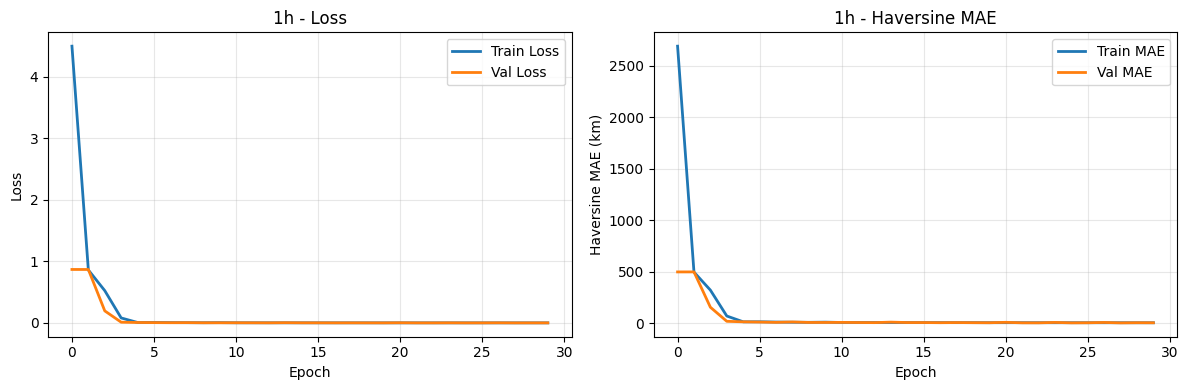


✓ 1h completed: Val MAE = 4.06 km (best at epoch 28)
✓ Results saved. Total configurations: 1

Current results summary:
horizon_name  horizon_min  val_haversine_mae  best_epoch
          1h           60           4.058648          28


In [7]:
# Configuration 1h: lookback 2h, horizon 1h
history_1h = train_lstm_config(lookback_steps=12, horizon_steps=6, horizon_name="1h")


## Configuration 2: 3h horizon



Configuration: 3h (lookback=180min, horizon=180min)
Total sequence length needed: 36 steps (360min)

1. Creating LSTM datasets...
Created targets: 4247485 rows remaining after shift(-18)
Train: 2776124 rows, 1535 vessels | Val: 656839 rows, 384 vessels | Test: 814522 rows, 480 vessels
group_train: 0            3791472
1            3791472
2            3791472
3            3791472
4            3791472
             ...    
4285267    677062300
4285268    677062300
4285269    677062300
4285270    677062300
4285271    677062300
Name: MMSI, Length: 2776124, dtype: int64
Eligible vessels: 1321 train, 330 val, 422 test

=== Creating TRAIN sequences ===
Creating sliding windows for 1321 vessels...
  Processing vessel 50/1321 (MMSI: 215896000) - 1118 sequences
  Processing vessel 100/1321 (MMSI: 229680000) - 546 sequences
  Processing vessel 150/1321 (MMSI: 244130525) - 1601 sequences
  Processing vessel 200/1321 (MMSI: 255806213) - 3384 sequences
  Processing vessel 250/1321 (MMSI: 258734000)

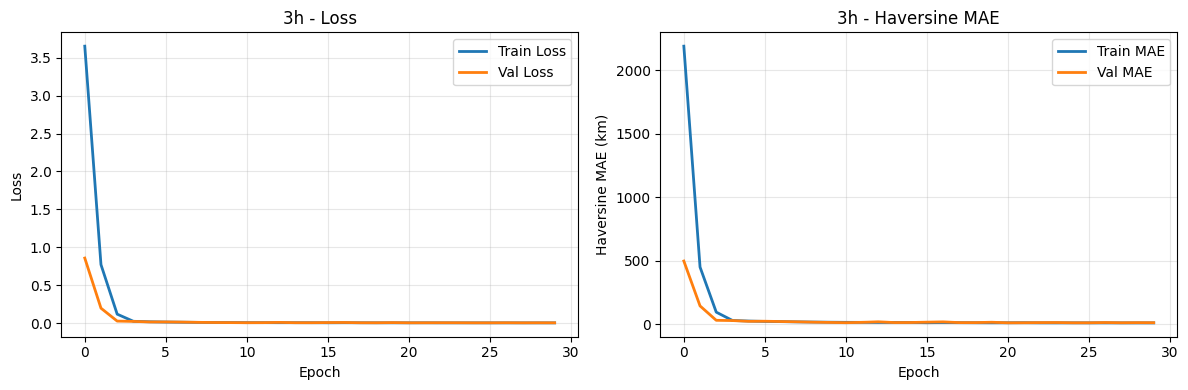


✓ 3h completed: Val MAE = 10.91 km (best at epoch 21)
✓ Results saved. Total configurations: 2

Current results summary:
horizon_name  horizon_min  val_haversine_mae  best_epoch
          1h           60           4.058648          28
          3h          180          10.913044          21


In [8]:
# Configuration 3h: lookback 3h, horizon 3h
history_3h = train_lstm_config(lookback_steps=18, horizon_steps=18, horizon_name="3h")


## Configuration 3: 6h horizon



Configuration: 6h (lookback=360min, horizon=360min)
Total sequence length needed: 72 steps (720min)

1. Creating LSTM datasets...
Created targets: 4204534 rows remaining after shift(-36)
Train: 2710578 rows, 1518 vessels | Val: 650909 rows, 380 vessels | Test: 843047 rows, 475 vessels
group_train: 0            3791472
1            3791472
2            3791472
3            3791472
4            3791472
             ...    
4288891    720066000
4288892    720066000
4288893    720066000
4288894    720066000
4288895    720066000
Name: MMSI, Length: 2710578, dtype: int64
Eligible vessels: 1296 train, 321 val, 408 test

=== Creating TRAIN sequences ===
Creating sliding windows for 1296 vessels...
  Processing vessel 50/1296 (MMSI: 215873000) - 549 sequences
  Processing vessel 100/1296 (MMSI: 229723000) - 3661 sequences
  Processing vessel 150/1296 (MMSI: 244168000) - 3311 sequences
  Processing vessel 200/1296 (MMSI: 255806206) - 872 sequences
  Processing vessel 250/1296 (MMSI: 257919000) 

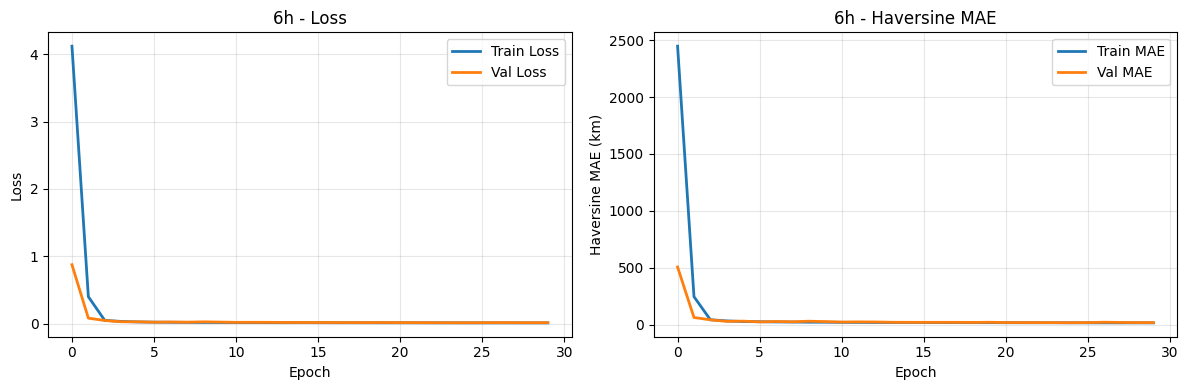


✓ 6h completed: Val MAE = 17.73 km (best at epoch 25)
✓ Results saved. Total configurations: 3

Current results summary:
horizon_name  horizon_min  val_haversine_mae  best_epoch
          1h           60           4.058648          28
          3h          180          10.913044          21
          6h          360          17.730869          25


In [9]:
# Configuration 6h: lookback 6h, horizon 6h
history_6h = train_lstm_config(lookback_steps=36, horizon_steps=36, horizon_name="6h")


## Configuration 4: 12h horizon



Configuration: 12h (lookback=720min, horizon=720min)
Total sequence length needed: 144 steps (1440min)

1. Creating LSTM datasets...
Created targets: 4120299 rows remaining after shift(-72)
Train: 2651894 rows, 1478 vessels | Val: 687687 rows, 370 vessels | Test: 780718 rows, 462 vessels
group_train: 0            3791472
1            3791472
2            3791472
3            3791472
4            3791472
             ...    
4290797    720202000
4290798    720202000
4290799    720202000
4290800    720202000
4290801    720202000
Name: MMSI, Length: 2651894, dtype: int64
Eligible vessels: 1236 train, 315 val, 396 test

=== Creating TRAIN sequences ===
Creating sliding windows for 1236 vessels...
  Processing vessel 50/1236 (MMSI: 215933000) - 400 sequences
  Processing vessel 100/1236 (MMSI: 232012089) - 1511 sequences
  Processing vessel 150/1236 (MMSI: 245347000) - 1223 sequences
  Processing vessel 200/1236 (MMSI: 256278000) - 718 sequences
  Processing vessel 250/1236 (MMSI: 30327000

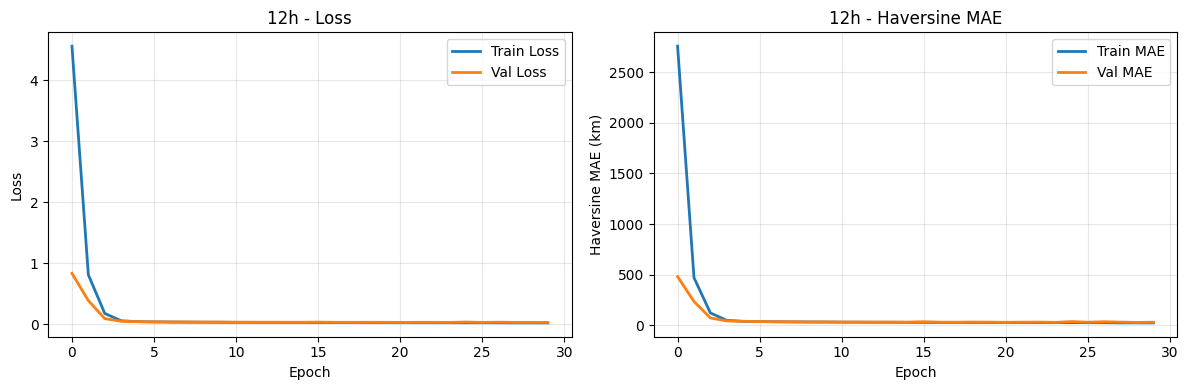


✓ 12h completed: Val MAE = 29.36 km (best at epoch 29)
✓ Results saved. Total configurations: 4

Current results summary:
horizon_name  horizon_min  val_haversine_mae  best_epoch
          1h           60           4.058648          28
          3h          180          10.913044          21
          6h          360          17.730869          25
         12h          720          29.362883          29


In [10]:
# Configuration 12h: lookback 12h, horizon 12h
history_12h = train_lstm_config(lookback_steps=72, horizon_steps=72, horizon_name="12h")


## Configuration 5: 24h horizon



Configuration: 24h (lookback=960min, horizon=1440min)
Total sequence length needed: 240 steps (2400min)

1. Creating LSTM datasets...
Created targets: 3958145 rows remaining after shift(-144)
Train: 2584707 rows, 1410 vessels | Val: 616447 rows, 353 vessels | Test: 756991 rows, 441 vessels
group_train: 0            3791472
1            3791472
2            3791472
3            3791472
4            3791472
             ...    
4290725    720202000
4290726    720202000
4290727    720202000
4290728    720202000
4290729    720202000
Name: MMSI, Length: 2584707, dtype: int64
Eligible vessels: 1169 train, 285 val, 337 test

=== Creating TRAIN sequences ===
Creating sliding windows for 1169 vessels...
  Processing vessel 50/1169 (MMSI: 219000034) - 787 sequences
  Processing vessel 100/1169 (MMSI: 232045875) - 1435 sequences
  Processing vessel 150/1169 (MMSI: 248006000) - 430 sequences
  Processing vessel 200/1169 (MMSI: 257083330) - 1327 sequences
  Processing vessel 250/1169 (MMSI: 304844

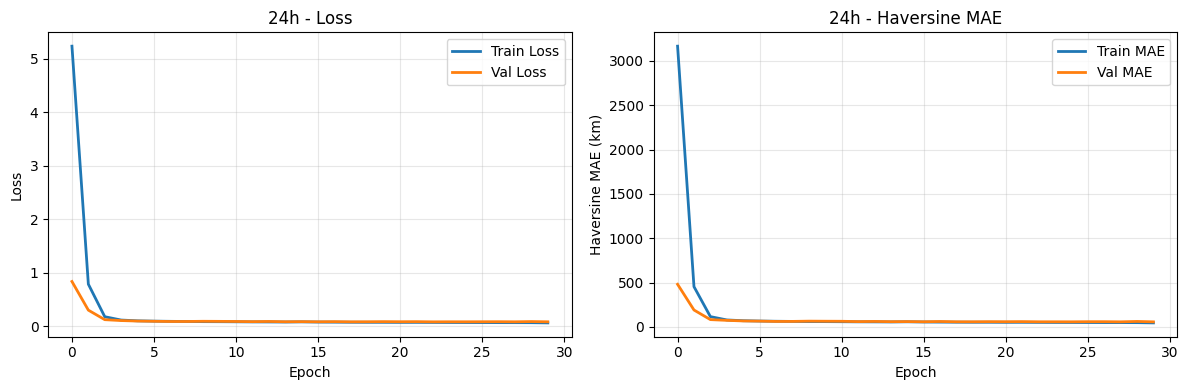


✓ 24h completed: Val MAE = 58.50 km (best at epoch 30)
✓ Results saved. Total configurations: 5

Current results summary:
horizon_name  horizon_min  val_haversine_mae  best_epoch
          1h           60           4.058648          28
          3h          180          10.913044          21
          6h          360          17.730869          25
         12h          720          29.362883          29
         24h         1440          58.498672          30


In [11]:
# Configuration 24h: lookback 16h, horizon 24h
history_24h = train_lstm_config(lookback_steps=96, horizon_steps=144, horizon_name="24h")


## Final Results Summary


In [12]:
# Display final results
print("="*60)
print("FINAL LSTM RESULTS SUMMARY")
print("="*60)
print(lstm_results_df[['horizon_name', 'horizon_min', 'val_haversine_mae', 'best_epoch', 'n_train_sampled', 'n_val_sampled']].to_string(index=False))
print("\n" + "="*60)


FINAL LSTM RESULTS SUMMARY
horizon_name  horizon_min  val_haversine_mae  best_epoch  n_train_sampled  n_val_sampled
          1h           60           4.058648          28           200000          60000
          3h          180          10.913044          21           200000          60000
          6h          360          17.730869          25           200000          60000
         12h          720          29.362883          29           200000          60000
         24h         1440          58.498672          30           200000          60000



## Conclusion and Interpretation

### Model Performance Summary

The LSTM model demonstrates **strong performance** across all prediction horizons, with validation MAE ranging from **4.06 km (1h)** to **58.50 km (24h)**. Key observations:

### Key Insights

**1. Temporal Sequence Learning:**
LSTM models successfully learn temporal dependencies in vessel trajectories. The stacked architecture (128→64 units) captures both short-term dynamics (speed changes, course adjustments) and longer-term patterns (route segments, navigation behavior).

**2. Horizon Scaling:**
Error increases more or less linearly with horizon (4 km → 58 km over 24h), indicating the model maintains consistent relative accuracy. This is expected as uncertainty grows with prediction distance.

**3. Hyperparameter Exploration:**
I tested various configurations to optimize performance:
- **Sample sizes**: Tested reduced sample sizes (100k/30k) to match ML model training data, but performance degraded moderately (1-22% worse) without significant benefits
- **Resampling intervals**: Tested 15-minute resampling intervals to reduce sequence redundancy, but results showed mixed performance (slightly worse on 1h, better on 3h-6h, worse again on 12h-24h) compared to 10-minute intervals
- **Conclusion**: The current configuration (10-minute resampling, 200k/60k samples) provides the best balance between performance and computational efficiency

### Limitations and Future Improvements

**Current limitations:**
- **Sample size**: Using 200k/60k samples may limit learning on complex patterns
- **Architecture**: Dropout disabled (0.0) - could be tuned for better generalization
- **Feature set**: Only using LAT, LON, SOG, COG - could add Heading, Status, or derived features

**Potential improvements:**
- **Attention mechanisms**: Add attention layers to focus on relevant timesteps
- **Bidirectional LSTM**: Process sequences in both directions for richer context
- **Hyperparameter tuning**: Systematic search for optimal architecture and training parameters

### Next Steps

Results from this notebook will be compared with baseline and ML models in **Notebook 9** to determine the optimal approach for different prediction horizons and use cases.
